<a href="https://colab.research.google.com/github/Khomiakov7706/Hierarchy_Analysis_Method/blob/develop/Requirement_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация формулировок требований

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', 500)

In [ ]:
data = pd.read_csv('train_test_withcols1.csv')

In [ ]:
data = data.drop('req_type', 1)
data = data.drop('test_scenario', 1)
data = data.rename(columns={'requirement': 'requirement_text'})

In [ ]:
requirement_classes = list(data.columns[2:].values)

In [ ]:
all_words = data['requirement_text'].str.split(expand=True).unstack().value_counts()

# Лемматизация

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivankhomiakov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def lemmatization(text):
    '''a function for lemmatization'''
    text = [lemmatizer.lemmatize(word.lower()) for word in text.split()]
    # joining the list of words with space separator
    return " ".join(text)

In [ ]:
data['lemmatized_requirement'] = data['requirement_text'].apply(lemmatization)

Убираем стоп-слова

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivankhomiakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words 
    text = [word for word in text.split() if word not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [ ]:
data['lemmatized_requirement'] = data['lemmatized_requirement'].apply(stopwords)

In [ ]:
import re
regex = re.compile('[^a-zA-Z а-яА-Я]')

In [ ]:
data.lemmatized_requirement = data.lemmatized_requirement.apply(lambda x: regex.sub('',x))

# Выявление признаков из датасета

## Синтетические признаки

составляем набор признаков на основе текста Dataframe

Количество слов в тексте требования 

In [ ]:
data['words_in_requirement'] = (
    data['requirement_text'].str.split().apply(len))

Кол-во слов в тексте лемматизированного требования

In [ ]:
data['words_in_lemmatized_req'] = (
    data['lemmatized_requirement'].str.split().apply(len))

Кол-во исключенных слов при лемматизации

In [ ]:
data['words_diffence'] = (
    data['words_in_requirement']-data['words_in_lemmatized_req'])

In [ ]:
additional_parameters = data.columns[-3:]

## Слова-признаки

Выписываем наиболее используемые слова как признаки

In [ ]:
for word in bag_of_word:
    data[word]=data['lemmatized_requirement'].apply(lambda x: x.count(str (' ' + word + ' ')))

Составляем словарь слов для разных классов с указанием количества используемых слов

In [ ]:
class_dict = dict()
for c in range(len(requirement_classes)):
    class_dict[requirement_classes[c]] = data[data[requirement_classes[c]]==1]['lemmatized_requirement'].str.split(expand=True).unstack().value_counts().head(15)

Составляем мешок уникальных слов для каждого класса

In [ ]:
bag_of_word = []
for i in requirement_classes:
    for j in class_dict[i].index:
        if not (j in bag_of_word):
            bag_of_word.append(j)

Создаем разметку данных

In [ ]:
target = requirement_classes
features = bag_of_word
for i in additional_parameters:
    features.append(i)

# Разбиение на тестовую и валидационную выборки для каждого класса требований

Всего 26 классов

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def split_train_test (dataframe_, target_, features_):
        
        X_train, X_test, y_train, y_test = train_test_split(dataframe_[features_],dataframe_[target_],test_size=0.2, random_state=77, stratify=dataframe_[target_])
        
        return X_train, X_test, y_train, y_test

In [ ]:
class_dict['Verification of Account Details and Settings'].index

Index(['user', 'contact', 'account', 'information', 'field', 'number', 'shall',
       'include', 'profile', 'email', 'id', 'password', 'website', 'phone',
       'address'],
      dtype='object')

In [ ]:
X_class_train = dict()
X_class_test = dict()
y_class_train = dict()
y_class_test = dict()

for cl in requirement_classes:
    X_class_train[cl],X_class_test[cl],y_class_train[cl],y_class_test[cl]=split_train_test(data, cl, class_dict[cl].index)

# Нормализация

In [ ]:
from sklearn.preprocessing import MinMaxScaler


Нормализация обучающей выборки

In [ ]:
scaler = dict()
scaler_params = dict()
for cl in requirement_classes:
    scaler[cl] = MinMaxScaler()
    X_class_train[cl] = scaler[cl].fit_transform(X_class_train[cl])

Нормализация тестовой выборки на сонове парамтеров обучающей

In [ ]:
scaler_ = MinMaxScaler()
for cl in requirement_classes:
#    scaler[cl].get_params()
    X_class_test[cl]=scaler[cl].transform(X_class_test[cl])

# Обучение модели

Так как классификация будет проводиться по каждому из классов независимо, разбиение на тестовую и обучающую выборки будет проводиться для каждого из классов отдельно

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
model_class_lr = dict()
model_lr_ = LogisticRegression() # Используем модель с параметрами по умолчанию

for cl in range(len(requirement_classes)):
    model_lr_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_lr[requirement_classes[cl]] = model_lr_

Наивный Байес

In [ ]:
from sklearn.naive_bayes import GaussianNB
model_nb_ = GaussianNB() # Используем модель с параметрами по умолчанию

model_class_nb = dict()
for cl in range(len(requirement_classes)):
    model_nb_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_nb[requirement_classes[cl]] = model_nb_

k-ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_knn_ = KNeighborsClassifier() # Используем модель с параметрами по умолчанию

model_class_knn = dict()
for cl in range(len(requirement_classes)):
    model_knn_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_knn[requirement_classes[cl]] = model_knn_

Метод решающих деревьев

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model_dtc_ = DecisionTreeClassifier() # Используем модель с параметрами по умолчанию

model_class_dtc = dict()
for cl in range(len(requirement_classes)):
    model_dtc_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_dtc[requirement_classes[cl]] = model_dtc_

Метод поддерживающих векторов

In [ ]:
from sklearn.svm import SVC
model_svc_ = SVC() # Используем модель с параметрами по умолчанию

model_class_svc = dict()
for cl in range(len(requirement_classes)):
    model_svc_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_svc[requirement_classes[cl]] = model_svc_

Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf_ = RandomForestClassifier() # Используем модель с параметрами по умолчанию

model_class_rf = dict()
for cl in range(len(requirement_classes)):
    model_rf_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_rf[requirement_classes[cl]] = model_rf_

## Посмотрим метрики для каждого класса и метода

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
lr_accuracy_test = dict()
lr_accuracy_train = dict()
for cl in requirement_classes:
    lr_accuracy_train[cl] = accuracy_score(y_class_train[cl], model_class_lr[cl].predict(X_class_train[cl]))
    lr_accuracy_test[cl] = accuracy_score(y_class_test[cl], model_class_lr[cl].predict(X_class_test[cl]))
    

In [ ]:
nb_accuracy_test = dict()
nb_accuracy_train = dict()
for cl in requirement_classes:
    nb_accuracy_train[cl] = accuracy_score(y_class_train[cl], model_class_nb[cl].predict(X_class_train[cl]))
    nb_accuracy_test[cl] = accuracy_score(y_class_test[cl], model_class_nb[cl].predict(X_class_test[cl]))
    

In [ ]:
knn_accuracy_test = dict()
knn_accuracy_train = dict()
for cl in requirement_classes:
    knn_accuracy_train[cl] = accuracy_score(y_class_train[cl], model_class_knn[cl].predict(X_class_train[cl]))
    knn_accuracy_test[cl] = accuracy_score(y_class_test[cl], model_class_knn[cl].predict(X_class_test[cl]))
    

In [ ]:
dtc_accuracy_test = dict()
dtc_accuracy_train = dict()
for cl in requirement_classes:
    dtc_accuracy_train[cl] = accuracy_score(y_class_train[cl], model_class_dtc[cl].predict(X_class_train[cl]))
    dtc_accuracy_test[cl] = accuracy_score(y_class_test[cl], model_class_dtc[cl].predict(X_class_test[cl]))
    

In [ ]:
svc_accuracy_test = dict()
svc_accuracy_train = dict()
for cl in requirement_classes:
    svc_accuracy_train[cl] = accuracy_score(y_class_train[cl], model_class_svc[cl].predict(X_class_train[cl]))
    svc_accuracy_test[cl] = accuracy_score(y_class_test[cl], model_class_svc[cl].predict(X_class_test[cl]))
    

In [ ]:
rf_accuracy_test = dict()
rf_accuracy_train = dict()
for cl in requirement_classes:
    rf_accuracy_train[cl] = accuracy_score(y_class_train[cl], model_class_rf[cl].predict(X_class_train[cl]))
    rf_accuracy_test[cl] = accuracy_score(y_class_test[cl], model_class_rf[cl].predict(X_class_test[cl]))
    

## Расчет среднего значения DS-метрики

In [ ]:
classifiers = list({'lr', 'nb', 'knn', 'dtc', 'svc', 'rf'})
mean_train_accuracy = dict()
mean_test_accuracy = dict()

for i in classifiers:
    mean_train_accuracy[i] = 0.0
    mean_test_accuracy[i] = 0.0


In [ ]:
print('Логистическая регрессия')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',lr_accuracy_train[cl])
    print('Точность на тестовой выборке: ', lr_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy[classifiers[0]] += lr_accuracy_train[cl]
    mean_test_accuracy[classifiers[0]] += lr_accuracy_test[cl]
mean_train_accuracy['lr'] = mean_train_accuracy['lr']/len(requirement_classes)
mean_test_accuracy['lr'] = mean_test_accuracy['lr']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['lr'])
print ('mean test accuracy: ', mean_test_accuracy['lr'])

Логистическая регрессия
mean train accuracy:  0.939713613724405
mean test accuracy:  0.93912562257886


In [ ]:
print('Наивный Байес')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',nb_accuracy_train[cl])
    print('Точность на тестовой выборке: ', nb_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['nb'] += nb_accuracy_train[cl]
    mean_test_accuracy['nb'] += nb_accuracy_test[cl]
mean_train_accuracy['nb'] = mean_train_accuracy['nb']/len(requirement_classes)
mean_test_accuracy['nb'] = mean_test_accuracy['nb']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['nb'])
print ('mean test accuracy: ', mean_test_accuracy['nb'])

Наивный Байес
mean train accuracy:  0.8432484781405643
mean test accuracy:  0.8436635307138906


In [ ]:
print('k-ближайших соседей')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',knn_accuracy_train[cl])
    print('Точность на тестовой выборке: ', knn_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['knn'] += knn_accuracy_train[cl]
    mean_test_accuracy['knn'] += knn_accuracy_test[cl]
mean_train_accuracy['knn'] = mean_train_accuracy['knn']/len(requirement_classes)
mean_test_accuracy['knn'] = mean_test_accuracy['knn']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['knn'])
print ('mean test accuracy: ', mean_test_accuracy['knn'])

k-ближайших соседей
mean train accuracy:  0.914602933038185
mean test accuracy:  0.9150525733259547


In [ ]:
print('Метод решающих деревьев')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',dtc_accuracy_train[cl])
    print('Точность на тестовой выборке: ', dtc_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['dtc'] += dtc_accuracy_train[cl]
    mean_test_accuracy['dtc'] += dtc_accuracy_test[cl]
mean_train_accuracy['dtc'] = mean_train_accuracy['dtc']/len(requirement_classes)
mean_test_accuracy['dtc'] = mean_test_accuracy['dtc']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['dtc'])
print ('mean test accuracy: ', mean_test_accuracy['dtc'])

Метод решающих деревьев
mean train accuracy:  0.8889388489208634
mean test accuracy:  0.8911178749308247


In [ ]:
print('Метод опорных векторов')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',svc_accuracy_train[cl])
    print('Точность на тестовой выборке: ', svc_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['svc'] += svc_accuracy_train[cl]
    mean_test_accuracy['svc'] += svc_accuracy_test[cl]
mean_train_accuracy['svc'] = mean_train_accuracy['svc']/len(requirement_classes)
mean_test_accuracy['svc'] = mean_test_accuracy['svc']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['svc'])
print ('mean test accuracy: ', mean_test_accuracy['svc'])

Метод опорных векторов
mean train accuracy:  0.926777808522413
mean test accuracy:  0.9269507470946322


In [ ]:
print('Случайный лес')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',rf_accuracy_train[cl])
    print('Точность на тестовой выборке: ', rf_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['rf'] += rf_accuracy_train[cl]
    mean_test_accuracy['rf'] += rf_accuracy_test[cl]
mean_train_accuracy['rf'] = mean_train_accuracy['rf']/len(requirement_classes)
mean_test_accuracy['rf'] = mean_test_accuracy['rf']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['rf'])
print ('mean test accuracy: ', mean_test_accuracy['rf'])

Случайный лес
mean train accuracy:  0.9034656889872716
mean test accuracy:  0.9037078029883786


# Визуализация результатов

методом линейной регрессии получилась следующая точность классификации для каждого класса:

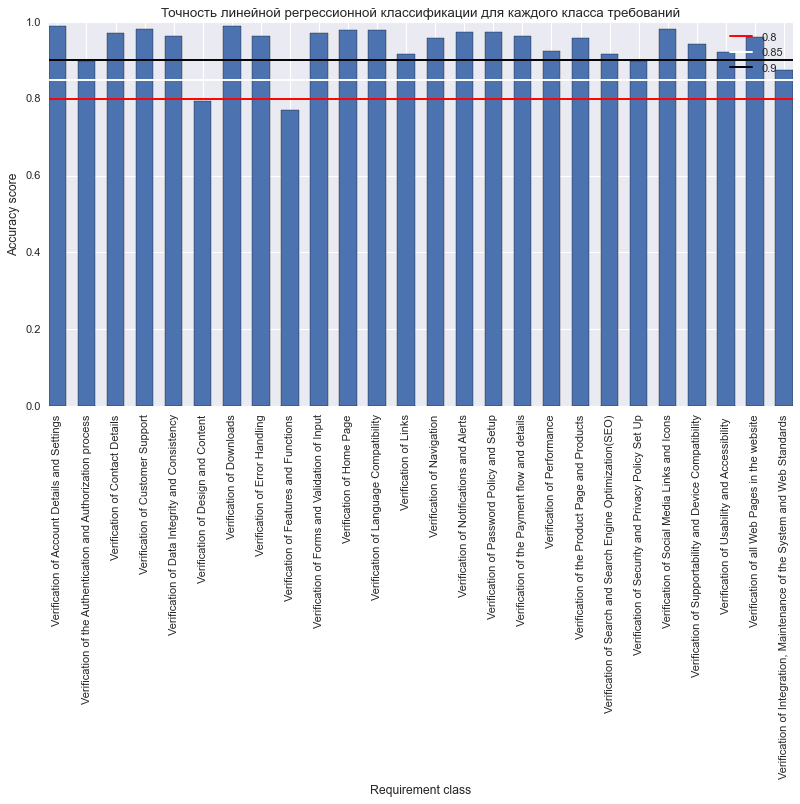

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(requirement_classes,lr_accuracy_test.values(), width=0.6)
plt.title('Точность линейной регрессионной классификации для каждого класса требований')
a = plt.xticks(rotation=90)
plt.axhline(0.8,c='r',label='0.8')
plt.axhline(0.85,c='w',label='0.85')
plt.axhline(0.9,c='black',label='0.9')
plt.legend()
plt.autoscale()
plt.xlabel('Requirement class')
plt.ylabel('Accuracy score')
plt.show()

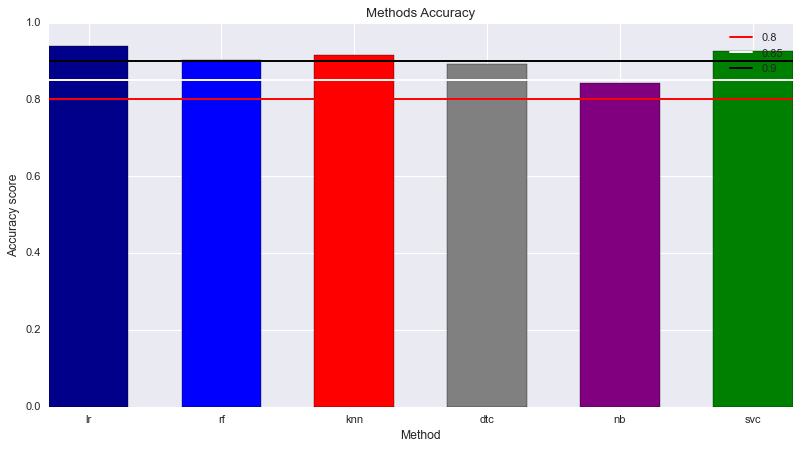

In [ ]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers,mean_test_accuracy.values(),width=0.6, color={'red','green','blue','purple', 'grey','darkblue'})
plt.title('Methods Accuracy')
plt.axhline(0.8,c='r',label='0.8')
plt.axhline(0.85,c='w',label='0.85')
plt.axhline(0.9,c='black',label='0.9')
plt.legend()
plt.autoscale()
plt.xlabel('Method')
plt.ylabel('Accuracy score')
plt.show()

In [ ]:
print ('method', '\t', 'train accuracy', '\t', 'test accuracy', '\n')
for i in classifiers:
    print (i, '\t', mean_train_accuracy[i], '\t', mean_test_accuracy[i])

method 	 train accuracy 	 test accuracy 

lr 	 0.939713613724405 	 0.93912562257886
rf 	 0.9034656889872716 	 0.9037078029883786
knn 	 0.914602933038185 	 0.9150525733259547
dtc 	 0.8889388489208634 	 0.8911178749308247
nb 	 0.8432484781405643 	 0.8436635307138906
svc 	 0.926777808522413 	 0.9269507470946322
